# Exploratory Data Analysis - Financial Loans

## 1. Introduction
The report aims to provide visualisations of the data to help evaluate the portfolio and identify key variables that indicate which loans are likely to produce a loss.

## 2. Data Overview & Load Data
The dataset contains 51481 rows and 39 columns. The schema can be found [here](./loan_dataset_schema.ipynb).

In [3]:
# Import modules and classes
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker


# Load the clean loan data into a DataFrame
df = pd.read_csv('loans_data_clean.csv', parse_dates=['last_payment_date','issue_date'])
# Create a copy of the DataFrame for backup
loan_data_copy = df.copy()

## 3. The Current State of Loans

**Aim : Summarise what percentage of the loans have been currently recovered compared to the total amount to be paid.**

To calculate what percentage of loans have been recovered the Fully Paid loans are summed and divided by the total number of loans.

In [ ]:
# Calculate percentage breakdown of loan_status
fully_paid_pct =((df['loan_status'] == 'Fully Paid').sum() / len(df['loan_status']))*100
current_pct =((df['loan_status'] == 'Current').sum() / len(df['loan_status']))*100
charged_off_pct =((df['loan_status'] == 'Charged Off').sum() / len(df['loan_status']))*100
late_pct = 100 - fully_paid_pct - charged_off_pct -current_pct
print(f'Fully Paid Loans Percentage: {fully_paid_pct:.0f}%')
print(f'Current Loans Percentage: {current_pct:.0f}%')
print(f'Late Loans Percentage: {late_pct:.0f}%')
print(f'Charged Off Loans Percentage: {charged_off_pct:.0f}%')

Fully Paid Loans Percentage: 51%
Current Loans Percentage: 35%
Late Loans Percentage: 4%
Charged Off Loans Percentage: 10%


Half of the loans are recovered with the other half in the process of being paid of have defaulted.

To calculate what percentage of the loaned amount has been recovered we must calculate a new variable. A new column called total_amount_expected is added to the data frame. It is the total amount the company expects to receive in return (including interest). This is calculated by multiplying the instalment column (which accounts for interest) and multiplying it by the term column. 

In [5]:
# Calculate total_amount_expected 
df['total_amount_expected'] = df['term'] * df['instalment']

expected_revenue = df['total_amount_expected'].sum()
revenue = df['total_payment'].sum()

# Calculate the recovery_percentage
recovery_percentage = (revenue / expected_revenue ) * 100
print(f'Recovery Percentage: {recovery_percentage:.0f}%')


Recovery Percentage: 71%


The recovery percentage is 71%. This means most of the invested amount have been recovered, the remaining 29% is a mix of money that has been lost or expected to be repaid. The percentage of loss can be found in the Loss section of the report.

**Aim : Calculate how much will be paid back in 6 months time with interest.**

In [6]:
# Exclude loans that are either 'Charged_Off' or 'Fully Paid'
df_filtered = df[~df['loan_status'].isin(['Charged_Off', 'Fully Paid'])]

df_filtered['amount_paid_6_months'] = df['instalment'] * 6  

six_month_projection = df_filtered['amount_paid_6_months'].sum()
print(f"Six Month Revenue Projection: £{six_month_projection:.0f}")

expected_percentage = (six_month_projection / expected_revenue ) * 100
print(f"Six Month Expected Recovery Percentage: {expected_percentage:.0f}%")

Six Month Revenue Projection: £65530030
Six Month Expected Recovery Percentage: 7%


C:\Users\noemi\AppData\Local\Temp\ipykernel_22520\4143990520.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['amount_paid_6_months'] = df['instalment'] * 6


The company can expect to earn £65,530,030 in the next 6 months. 

### 3.1 Visualising the Current State of Loans

The recovery percentages will be plotted on a stacked bar graph to show how much of the expected revenue has been recovered. It has been split into 3 categories:

1. Already recovered : the total sum of payments as a percentage of the total expected amount.
2. Expected in 6 months : how much they expect from customers in the next 6 months who are currently paying off their loans.
3. Remaining to recover : the remaining amount to be recovered (including the loss from defaulted payments).

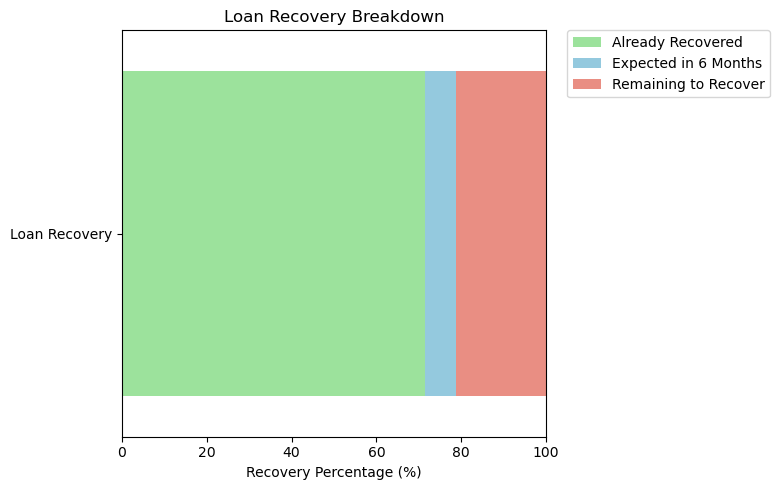

In [7]:
recovered_pct = recovery_percentage  # % of the total due has already been recovered
expected_pct  = expected_percentage  # % is expected in 6 months
remaining_pct = 100 - (recovered_pct + expected_pct)  # remaining amount

# Total due amount in £ 
total_due_sum = df['total_amount_expected'].sum() 

# Data for plotting
categories = ['Loan Recovery']
percentages = [recovered_pct, expected_pct, remaining_pct]
labels = ['Already Recovered', 'Expected in 6 Months', 'Remaining to Recover']
colors = ['lightgreen', 'skyblue', 'salmon']

# Create a figure
fig, ax = plt.subplots(figsize=(8, 5))

# Plot stacked horizontal bar chart
bottom = 0  # Track stacking positions
for pct, label, color in zip(percentages, labels, colors):
    sns.barplot(x=[pct], y=categories, color=color, label=label, left=bottom, ax=ax)
    bottom += pct  # Move bottom to stack the next bar

# Format y-axis (percentage)
ax.set_xlabel('Recovery Percentage (%)')
ax.set_xlim(0, 100)
ax.set_title('Loan Recovery Breakdown')


# Legend
ax.legend(loc='upper left')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.tight_layout()
plt.show()


From the graph we can see that most payments have been recovered and that in the next 6 months about 80% should be expected to be recovered.

## 4. Calculating Loss

**Aim : Calculate the percentage of loans have been a loss to the company and the absolute loss.**

Loans marked as Charged Off in the loan_status column represent a loss to the company, these are loans that are never paid back in full and the company has stopped trying to collect the debt.

### 4.1 Calculate the percentage of charged off loans

The Charged Off Percentage is calculated by counting the number of Charged Off loans and dividing it by the total number of loans.

In [8]:
# Calculate charged off percentage
charged_off_percentage =((df['loan_status'] == 'Charged Off').sum() / len(df['loan_amount']))*100
print(f'Charged Off Percentage: {charged_off_percentage:.0f}%')

Charged Off Percentage: 10%


 10% of the loans have been charged off.

### 4.2 Calculate absolute loss

 To calculate the loss from Charged Off loans we need to calculate the difference in the funded amount and the paid amount from Charged Off loans.

In [ ]:
# Calculate how much charged off loans paid before being charged off
total_charged_off_payment =df.loc[df['loan_status'] == 'Charged Off', 'total_payment'].sum()
print(f'Sum of total payment for charged off loans: £{total_charged_off_payment:.0f}')

# Calculate how much funding was given to charged off loans
total_charged_off_funded = df.loc[df['loan_status'] == 'Charged Off', 'funded_amount'].sum()
print(f'Sum of funded amount for charged off loans: £{total_charged_off_funded:.0f}')

# Calculate loss
loss = total_charged_off_funded - total_charged_off_payment
print(f'Loss: £{loss:.0f}')

Sum of total payment for charged off loans: £34845198
Sum of funded amount for charged off loans: £69712800
Loss: £34867602
This loss represents a 4% loss in expected revenue.


The company lost £34,867,602 to Charged Off loans.

## 5. Calculating Projected Loss

**Aim  : Calculate the loss in revenue Charged Off loans would have generated for the company if they had finished their term.**

In [10]:
# Calculate total expected revenue from Charged Off loans
charged_off_expected_payment = df.loc[df['loan_status'] == 'Charged Off', 'total_amount_expected'].sum()

# Calculate the difference between expected revenue and payments
expected_loss = charged_off_expected_payment - total_charged_off_payment
print(f'Expected Loss: £{expected_loss:.0f}')

Expected Loss: £57517840


The company lost £57,517,840 in expected revenue from Charged Off loans.

### 5.1 Visualising Projected Loss

**Aim : Visualise the loss projected over the remaining term of Charged Off loans.**

To calculate the remaining term we first must calculate how many monthly payments were made. The issue date of the loan is subtracted from the last payment date and then divided by 30 to calculate the number of months paid. This is then subtracted from the original term to give the number of remaining months expected to be paid. 

The projected loss is then grouped by the remaining term and summed to visualise the loss projected over the remaining term of Charged Off loans.

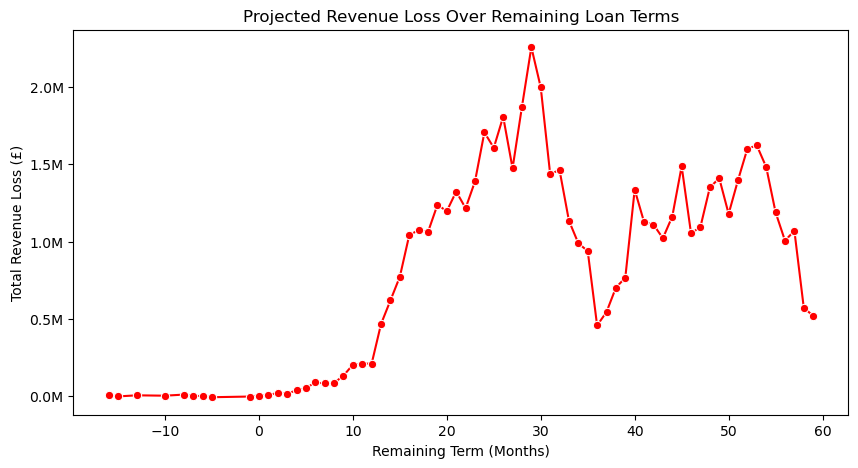

In [11]:
# Calculate how many months were paid
df['months_paid'] = (df['last_payment_date'] - df['issue_date']).dt.days // 30  # convert time  delta to days and divide by average month length (30)
df['months_remaining'] = df['term'] - df['months_paid']

# Calculate revenue loss for each loan
df['revenue_loss'] = df['total_amount_expected'] - df['total_payment']

# Filter for Charged Off loans
charged_off_loans = df[df['loan_status'] == 'Charged Off']

# Group by remaining term 
loss_over_time = charged_off_loans.groupby('months_remaining')['revenue_loss'].sum()

# Create the figure and axis
plt.figure(figsize=(10, 5))

# Plot using Seaborn
sns.lineplot(x=loss_over_time.index, y=loss_over_time.values, marker='o', color='red')

# Labels and title
plt.xlabel("Remaining Term (Months)")
plt.ylabel("Total Revenue Loss (£)")
plt.title("Projected Revenue Loss Over Remaining Loan Terms")

# Disable scientific notation
plt.ticklabel_format(style='plain', axis='y')

# Format y-axis to display in millions
def millions(x, pos):
    return f'{x*1e-6:.1f}M'

plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(millions))

# Show the plot
plt.show()


Terms can be 36 months of 60 months. We see a spikes around 29 months and 53 remaining months, both within 7 months of the standard term length. The company should make further investigations into loans that were charged off a few months after being issued. We also see a few negative remaining terms, these are due to late repayments that took longer than the expected payment schedule.

### 5.2 Possible Loss

**Aim : Calculate the total amount of loans with late payments and how much loss the company would incur if their status was changed to Charged Off.**


There are borrowers who are currently behind on their loan payments. This subset of loans represent a risk to company revenue. Predicting the possible loss to the company will help inform who they loan to in the future.

In [12]:
# Calculate the total amount of loans with late payments 
late_loans = df['loan_status'].str.startswith('Late', na=False)
late_loans_count = late_loans.sum()
print(f'Late Loans Count: {late_loans_count}')

Late Loans Count: 633


There are currently 633 loans late on payments.

What is the projected loss of these loans if the customer were to finish the full loan term?

In [13]:
#  How much loss the company would incur if their status was changed to Charged Off.

total_payment_late_loans =df.loc[late_loans, 'total_payment'].sum()
print(f'Late Loans Total Payment: £{total_payment_late_loans:.0f}')

expected_payment_late_loans =df.loc[late_loans, 'loan_amount'].sum()
print(f'Late Loans Total Expected Payment: £{expected_payment_late_loans:.0f}')

expected_loss = expected_payment_late_loans - total_payment_late_loans
print(f"Company loss if late loans' status was changed to Charged Off: £{expected_loss:.0f}")


Late Loans Total Payment: £6346067
Late Loans Total Expected Payment: £9495700
Company loss if late loans' status was changed to Charged Off: £3149633


The company would lose £3,149,633 if all late loans were to default now.

If loans that are late on payments converted to Charged Off, what percentage of total expected revenue do these loans and the loans who have already defaulted on their loan represent?

In [14]:
defaulted_loans_total_expected_revenue = expected_payment_late_loans + charged_off_expected_payment

default_revenue_percentage = (defaulted_loans_total_expected_revenue / expected_revenue ) * 100

print(f'Percentage of total expected revenue of defaulted loans: {default_revenue_percentage:.0f}%')

Percentage of total expected revenue of defaulted loans: 12%


Charged Off and late loans represent a potential loss of 12% of the expected revenue.

## 6. Indicators of Loss

**Aim : analyse the data to visualise the possible indicators that a customer will not be able to pay the loan.**

The Fully Paid, Charged Off and Late loans will be compared trends among high,medium and no risk loans. The Late loans group consist of two types 16-30 days late and 31-120 days late. They have been grouped for convenience.

In [ ]:
selected_statuses = ['Fully Paid', 'Charged Off']
late_mask = df['loan_status'].str.startswith('Late', na=False)

# Filter dataset including all "Late" loans
risk_loans = df[df['loan_status'].isin(selected_statuses) | late_mask].copy()

# Convert "Late (16-30 days)" and "Late (31-120 days)" into "Late"
risk_loans['loan_status'] = risk_loans['loan_status'].replace({
    'Late (16-30 days)': 'Late',
    'Late (31-120 days)': 'Late'
})


loan_status
Fully Paid     26051
Charged Off     5129
Late             633
Name: count, dtype: int64


### 6.1 Visualising Numeric Data

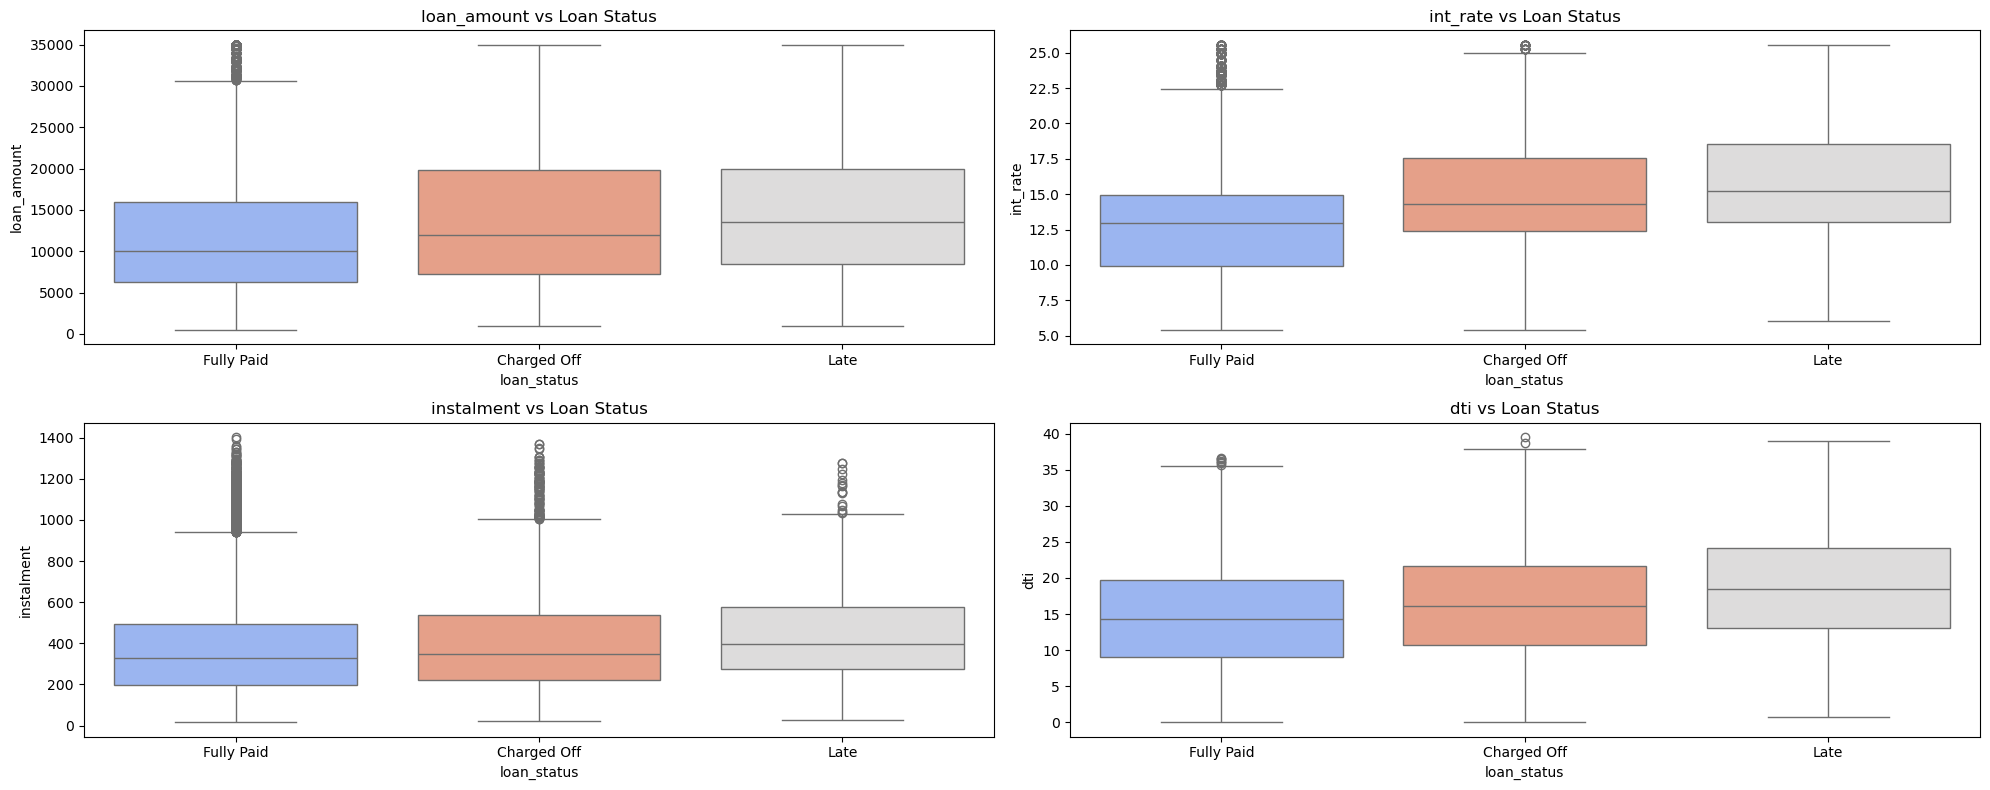

In [44]:
# Define numeric columns to analyze
numeric_columns = ['loan_amount', 'int_rate', 'instalment', 'dti']

hist_cols = [ 'annual_inc','delinq_2yrs']

# Define the number of rows and columns for the subplots
num_cols = 2  # Number of columns in the figure
num_rows = -(-len(numeric_columns) // num_cols)  # Ceiling division for rows

# Create a figure with multiple subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 4))
axes = axes.flatten()  # Flatten the array of axes for easy indexing

# Loop through each numeric column and plot comparisons
for i, col in enumerate(numeric_columns):
    sns.boxplot(data=risk_loans, x='loan_status', y=col, hue='loan_status',
                hue_order=["Fully Paid","Late","Charged Off"], 
                palette='coolwarm', ax=axes[i])
    axes[i].set_title(f"{col} vs Loan Status")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


We can see that medium and high risk loans have higher loan amounts, interest rates, instalments, and dti in comparison to fully paid loans.

### 6.2 Visualising Categorical Data
For the categorical data I have chosen to use visualise the data using bar plots from a randomly sampled dataset. This makes it easier to compare across the groups as Fully Paid is orders of magnitude bigger than the other two categories.

In [53]:
# number of samples in each group
print(risk_loans['loan_status'].value_counts())

# Create a randomly sampled df 
# sample size is the minimum sample size - size of the Late group
sampled_df = risk_loans.groupby('loan_status').apply(lambda x: x.sample(633, random_state=42)).reset_index(drop=True)


loan_status
Fully Paid     26051
Charged Off     5129
Late             633
Name: count, dtype: int64


C:\Users\noemi\AppData\Local\Temp\ipykernel_22520\2375179299.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = risk_loans.groupby('loan_status').apply(lambda x: x.sample(633, random_state=42)).reset_index(drop=True)


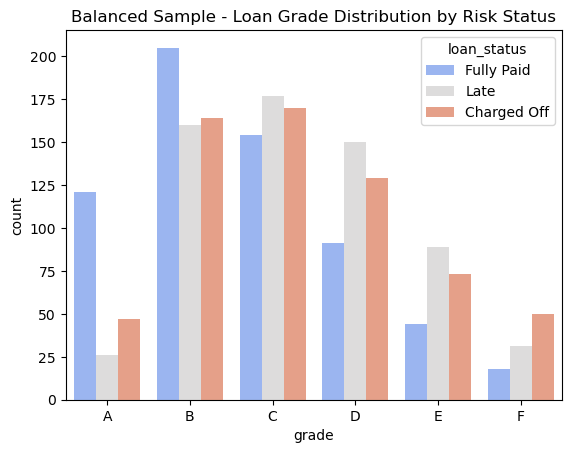

In [52]:
# Now plot bar plots on the sampled dataset
sns.countplot(data=sampled_df, x='grade', hue='loan_status', hue_order=["Fully Paid","Late","Charged Off"], palette='coolwarm',order=sorted(df['grade'].unique()))
plt.title("Balanced Sample - Loan Grade Distribution by Risk Status")
plt.show()

From the sampled bar plot we can see that Late and Charged Off loans are more frequent in lower grades.

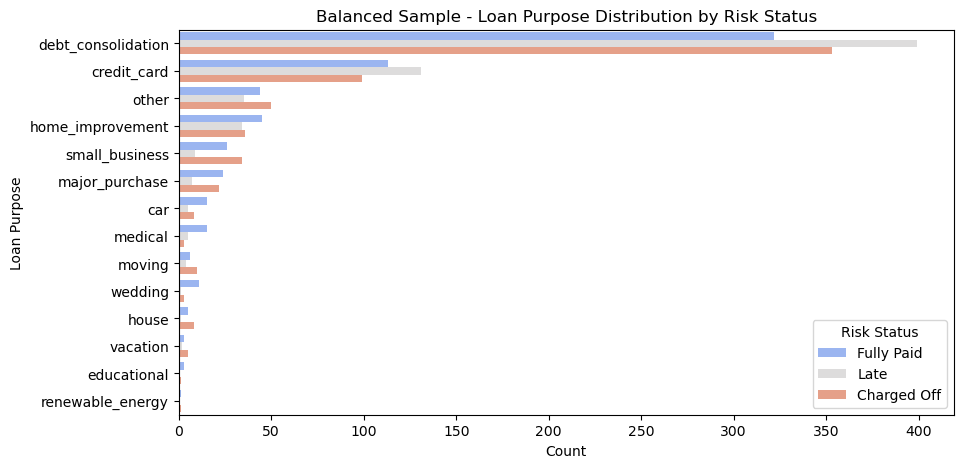

In [56]:
# Plot: Loan Purpose vs. Risk Status
plt.figure(figsize=(10, 5))
sns.countplot(data=sampled_df, y='purpose', hue='loan_status', hue_order=["Fully Paid", "Late","Charged Off"], palette='coolwarm', order=sampled_df['purpose'].value_counts().index)
plt.title("Balanced Sample - Loan Purpose Distribution by Risk Status")
plt.xlabel("Count")
plt.ylabel("Loan Purpose")
plt.legend(title="Risk Status")
plt.show()

Most loans are for debt consolidation. Late loans were the mode of the top two categories debt consolidation and credit card repayments.The small business category mode is Late loans which is another risk area. 

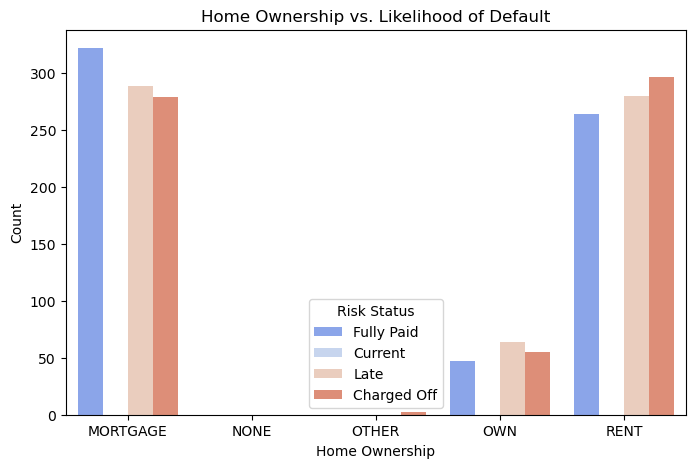

In [55]:
# Plot: Home Ownership vs. Risk Status
plt.figure(figsize=(8, 5))
sns.countplot(data=sampled_df, x='home_ownership', hue='loan_status', hue_order=["Fully Paid", "Current", "Late","Charged Off"], palette='coolwarm', order=sorted(df['home_ownership'].unique()))
plt.title("Home Ownership vs. Likelihood of Default")
plt.xlabel("Home Ownership")
plt.ylabel("Count")
plt.legend(title="Risk Status")
plt.show()

Most loans fall into the mortgage or rent category with the renting group containing a higher proportion of late and charged off loans. The mortgage group contains a similar frequency of risky loans, so it is not the strongest indicator of risk.

## 7. Conclusion

From this analysis we have learnt that the company has recovered 71% of its expected revenue and in six months that would expect to go up to 78%. 

10% of loans have been charged off which has caused a loss of over £34 million. 

4% of the loans are late, if they were to default now the loss to the company would be over £31 million.

There are many indicators of loss, the key ones are low grades, high interest rates and large loans.